### ConvLSTM_BIG - Stefano Maxenti - Riccardo Mencucci - "team_durian"

In [ ]:
# The following lines are needed in Gradient Paperspace because these libraries are not installed by default
!pip install scipy sklearn pandas seaborn pillow visualkeras attention

### Import libraries

In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
from keras import backend as K
print(tf.__version__)

2.6.0


Set seed for reproducibility

In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

Let's import the dataset

In [4]:
dataset = pd.read_csv('training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


Loading the dataset and taking a look at the data distribution

In [ ]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(200,50))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
inspect_dataframe(dataset, dataset.columns)

Sequential Train-Test split and normalization

(66528, 7) (2000, 7)


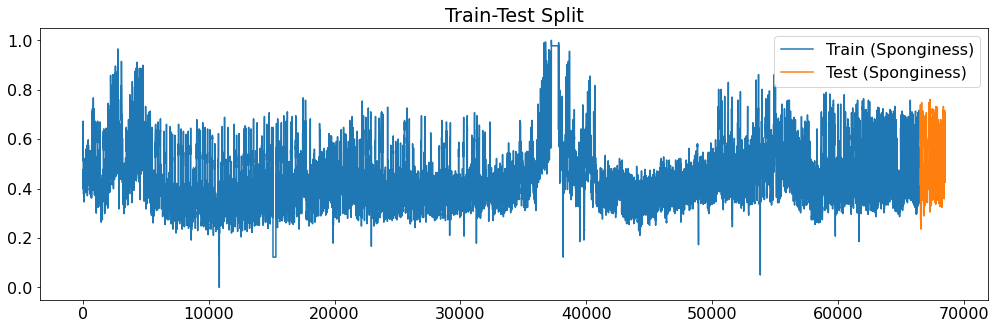

,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,0.556576,0.481134,0.612986,0.468044,0.613765,0.691885,0.629100
1,0.562874,0.485320,0.611573,0.465453,0.627575,0.690471,0.626693
2,0.559777,0.476949,0.611573,0.462934,0.606973,0.682070,0.626693
3,0.559777,0.476949,0.611573,0.465453,0.606973,0.621844,0.626693
4,0.550279,0.485320,0.610160,0.465453,0.620783,0.637254,0.626693


In [5]:
test_size = 2000
X_train_raw = dataset.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Sponginess, label='Train (Sponginess)')
plt.plot(X_test_raw.Sponginess, label='Test (Sponginess)')
plt.title('Train-Test Split')
plt.legend()
plt.show()
X_train_raw.head()

In [8]:
# We use sliding windows of 300 elements with stride equal to 1
window = 300
stride = 1

future = dataset[-window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
future.shape

(1, 300, 7)

In [9]:
def build_sequences(df, target_labels=['pollution'], window=400, stride=10, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

### Multivariate Forecasting

In [10]:
target_labels = dataset.columns
print(target_labels)
telescope = 1152 # 1152 is used because this model was trained before phase 2 was removed

Index(['Sponginess', 'Wonder level', 'Crunchiness', 'Loudness on impact',
       'Meme creativity', 'Soap slipperiness', 'Hype root'],
      dtype='object')


In [11]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((65148, 300, 7), (65148, 1152, 7), (648, 300, 7), (648, 1152, 7))

In [12]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(50,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

In [13]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 150

In [14]:
import os
from datetime import datetime


cwd = os.getcwd()

exps_dir = os.path.join('regression_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

#now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = "LSTM-Big"
exp_dir = os.path.join(exps_dir, model_name)# + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_best.ckpt'), 
                                                   save_weights_only=False, save_best_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True)
    callbacks.append(es_callback)
callbacks.append(tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=6, factor=0.5, min_lr=1e-7))

In [15]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square((y_pred - y_true))))
def root_mean_squared_error_denorm(y_true, y_pred):
    return K.sqrt(K.mean(K.square(((y_pred*(X_max-X_min)+X_min)) - (y_true*(X_max-X_min)+X_min))))#*(X_max-X_min)+X_min)))
 

def build_CONV_LSTM_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    convlstm = tfkl.Bidirectional(tfkl.LSTM(1024, return_sequences=True))(input_layer)
    convlstm = tfkl.Conv1D(128, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.Bidirectional(tfkl.LSTM(1024, return_sequences=True))(convlstm)
    convlstm = tfkl.Conv1D(256, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.MaxPool1D()(convlstm)
    convlstm = tfkl.Conv1D(512, 3, padding='same', activation='relu')(convlstm)
    convlstm = tfkl.GlobalAveragePooling1D()(convlstm)
    convlstm = tfkl.Dropout(.3)(convlstm)

    convlstm = tfkl.Dense(1024)(convlstm)
    convlstm = tfkl.Dropout(0.3)(convlstm)
    convlstm = tfkl.Dense(512)(convlstm)
    convlstm = tfkl.Dropout(0.1)(convlstm)
    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(convlstm)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae', root_mean_squared_error, root_mean_squared_error_denorm])

    # Return the model
    return model

In [16]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
#tfk.utils.plot_model(model, expand_nested=True)

2021-12-28 12:48:15.419129: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-28 12:48:15.432264: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-28 12:48:15.433363: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-28 12:48:15.435844: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-28 12:48:15.436850: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read f

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 300, 7)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 300, 2048)         8454144   
_________________________________________________________________
conv1d (Conv1D)              (None, 300, 128)          786560    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 150, 128)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150, 2048)         9445376   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 150, 256)          1573120   
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 75, 256)           0     

In [17]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    #validation_split=.2,
    validation_data = (X_test, y_test),
    callbacks = callbacks        
).history

2021-12-28 12:48:34.342970: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2101413888 exceeds 10% of free system memory.
2021-12-28 12:48:37.349324: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2101413888 exceeds 10% of free system memory.
2021-12-28 12:48:39.388751: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150


2021-12-28 12:48:44.896609: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8204


1018/1018 [==============================] - 306s 293ms/step - loss: 0.0303 - mae: 0.1109 - root_mean_squared_error: 0.1524 - root_mean_squared_error_denorm: 8.8875 - val_loss: 0.0189 - val_mae: 0.0973 - val_root_mean_squared_error: 0.1382 - val_root_mean_squared_error_denorm: 8.7295


2021-12-28 12:53:53.796077: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/150
1018/1018 [==============================] - 297s 292ms/step - loss: 0.0156 - mae: 0.0864 - root_mean_squared_error: 0.1248 - root_mean_squared_error_denorm: 7.4263 - val_loss: 0.0196 - val_mae: 0.1013 - val_root_mean_squared_error: 0.1403 - val_root_mean_squared_error_denorm: 8.5098
Epoch 3/150
1018/1018 [==============================] - 297s 292ms/step - loss: 0.0142 - mae: 0.0815 - root_mean_squared_error: 0.1190 - root_mean_squared_error_denorm: 7.2423 - val_loss: 0.0182 - val_mae: 0.0958 - val_root_mean_squared_error: 0.1359 - val_root_mean_squared_error_denorm: 8.3716


Epoch 4/150
1018/1018 [==============================] - 297s 292ms/step - loss: 0.0122 - mae: 0.0759 - root_mean_squared_error: 0.1102 - root_mean_squared_error_denorm: 6.6705 - val_loss: 0.0122 - val_mae: 0.0810 - val_root_mean_squared_error: 0.1110 - val_root_mean_squared_error_denorm: 6.0230


Epoch 5/150
1018/1018 [==============================] - 297s 292ms/step - loss: 0.0086 - mae: 0.0658 - root_mean_squared_error: 0.0928 - root_mean_squared_error_denorm: 5.2830 - val_loss: 0.0103 - val_mae: 0.0741 - val_root_mean_squared_error: 0.1015 - val_root_mean_squared_error_denorm: 5.7778


Epoch 6/150
1018/1018 [==============================] - 297s 292ms/step - loss: 0.0076 - mae: 0.0616 - root_mean_squared_error: 0.0872 - root_mean_squared_error_denorm: 4.9147 - val_loss: 0.0121 - val_mae: 0.0816 - val_root_mean_squared_error: 0.1107 - val_root_mean_squared_error_denorm: 5.7836
Epoch 7/150
1018/1018 [==============================] - 297s 292ms/step - loss: 0.0070 - mae: 0.0589 - root_mean_squared_error: 0.0834 - root_mean_squared_error_denorm: 4.7169 - val_loss: 0.0100 - val_mae: 0.0732 - val_root_mean_squared_error: 0.1002 - val_root_mean_squared_error_denorm: 5.3328


Epoch 8/150
1018/1018 [==============================] - 297s 292ms/step - loss: 0.0064 - mae: 0.0569 - root_mean_squared_error: 0.0802 - root_mean_squared_error_denorm: 4.5057 - val_loss: 0.0111 - val_mae: 0.0787 - val_root_mean_squared_error: 0.1057 - val_root_mean_squared_error_denorm: 5.3663
Epoch 9/150
1018/1018 [==============================] - 297s 292ms/step - loss: 0.0060 - mae: 0.0554 - root_mean_squared_error: 0.0776 - root_mean_squared_error_denorm: 4.3355 - val_loss: 0.0102 - val_mae: 0.0758 - val_root_mean_squared_error: 0.1014 - val_root_mean_squared_error_denorm: 5.0445
Epoch 10/150
1018/1018 [==============================] - 297s 292ms/step - loss: 0.0056 - mae: 0.0540 - root_mean_squared_error: 0.0747 - root_mean_squared_error_denorm: 4.1170 - val_loss: 0.0095 - val_mae: 0.0741 - val_root_mean_squared_error: 0.0972 - val_root_mean_squared_error_denorm: 4.7568


Epoch 11/150
1018/1018 [==============================] - 297s 292ms/step - loss: 0.0053 - mae: 0.0531 - root_mean_squared_error: 0.0728 - root_mean_squared_error_denorm: 3.9877 - val_loss: 0.0101 - val_mae: 0.0754 - val_root_mean_squared_error: 0.1000 - val_root_mean_squared_error_denorm: 4.9747
Epoch 12/150
1018/1018 [==============================] - 297s 292ms/step - loss: 0.0051 - mae: 0.0525 - root_mean_squared_error: 0.0716 - root_mean_squared_error_denorm: 3.9147 - val_loss: 0.0090 - val_mae: 0.0711 - val_root_mean_squared_error: 0.0947 - val_root_mean_squared_error_denorm: 4.9973


Epoch 13/150
1018/1018 [==============================] - 297s 291ms/step - loss: 0.0050 - mae: 0.0520 - root_mean_squared_error: 0.0708 - root_mean_squared_error_denorm: 3.8768 - val_loss: 0.0097 - val_mae: 0.0745 - val_root_mean_squared_error: 0.0983 - val_root_mean_squared_error_denorm: 4.8804
Epoch 14/150
1018/1018 [==============================] - 296s 291ms/step - loss: 0.0049 - mae: 0.0515 - root_mean_squared_error: 0.0700 - root_mean_squared_error_denorm: 3.8411 - val_loss: 0.0087 - val_mae: 0.0702 - val_root_mean_squared_error: 0.0931 - val_root_mean_squared_error_denorm: 4.6615


Epoch 15/150
1018/1018 [==============================] - 296s 291ms/step - loss: 0.0048 - mae: 0.0511 - root_mean_squared_error: 0.0692 - root_mean_squared_error_denorm: 3.7824 - val_loss: 0.0086 - val_mae: 0.0706 - val_root_mean_squared_error: 0.0924 - val_root_mean_squared_error_denorm: 4.6644


Epoch 16/150
1018/1018 [==============================] - 296s 291ms/step - loss: 0.0047 - mae: 0.0507 - root_mean_squared_error: 0.0688 - root_mean_squared_error_denorm: 3.7587 - val_loss: 0.0094 - val_mae: 0.0746 - val_root_mean_squared_error: 0.0970 - val_root_mean_squared_error_denorm: 4.7473
Epoch 17/150
1018/1018 [==============================] - 297s 291ms/step - loss: 0.0047 - mae: 0.0505 - root_mean_squared_error: 0.0684 - root_mean_squared_error_denorm: 3.7408 - val_loss: 0.0097 - val_mae: 0.0753 - val_root_mean_squared_error: 0.0983 - val_root_mean_squared_error_denorm: 4.6994
Epoch 18/150
1018/1018 [==============================] - 297s 291ms/step - loss: 0.0046 - mae: 0.0502 - root_mean_squared_error: 0.0681 - root_mean_squared_error_denorm: 3.7217 - val_loss: 0.0095 - val_mae: 0.0748 - val_root_mean_squared_error: 0.0975 - val_root_mean_squared_error_denorm: 4.7620
Epoch 19/150
1018/1018 [==============================] - 297s 291ms/step - loss: 0.0046 - mae: 0.0499 - r

In [22]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test[:,:864,:].flatten(),predictions[:,:864,:].flatten())
mean_absolute_error = tfk.metrics.mae(y_test[:,:864,:].flatten(),predictions[:,:864,:].flatten())
print(mean_squared_error, mean_absolute_error)
mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
print(mean_squared_error, mean_absolute_error)

(648, 1152, 7)
tf.Tensor(0.008984549, shape=(), dtype=float32) tf.Tensor(0.072916366, shape=(), dtype=float32)
tf.Tensor(0.008808875, shape=(), dtype=float32) tf.Tensor(0.07252976, shape=(), dtype=float32)


In [23]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(50,30))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()


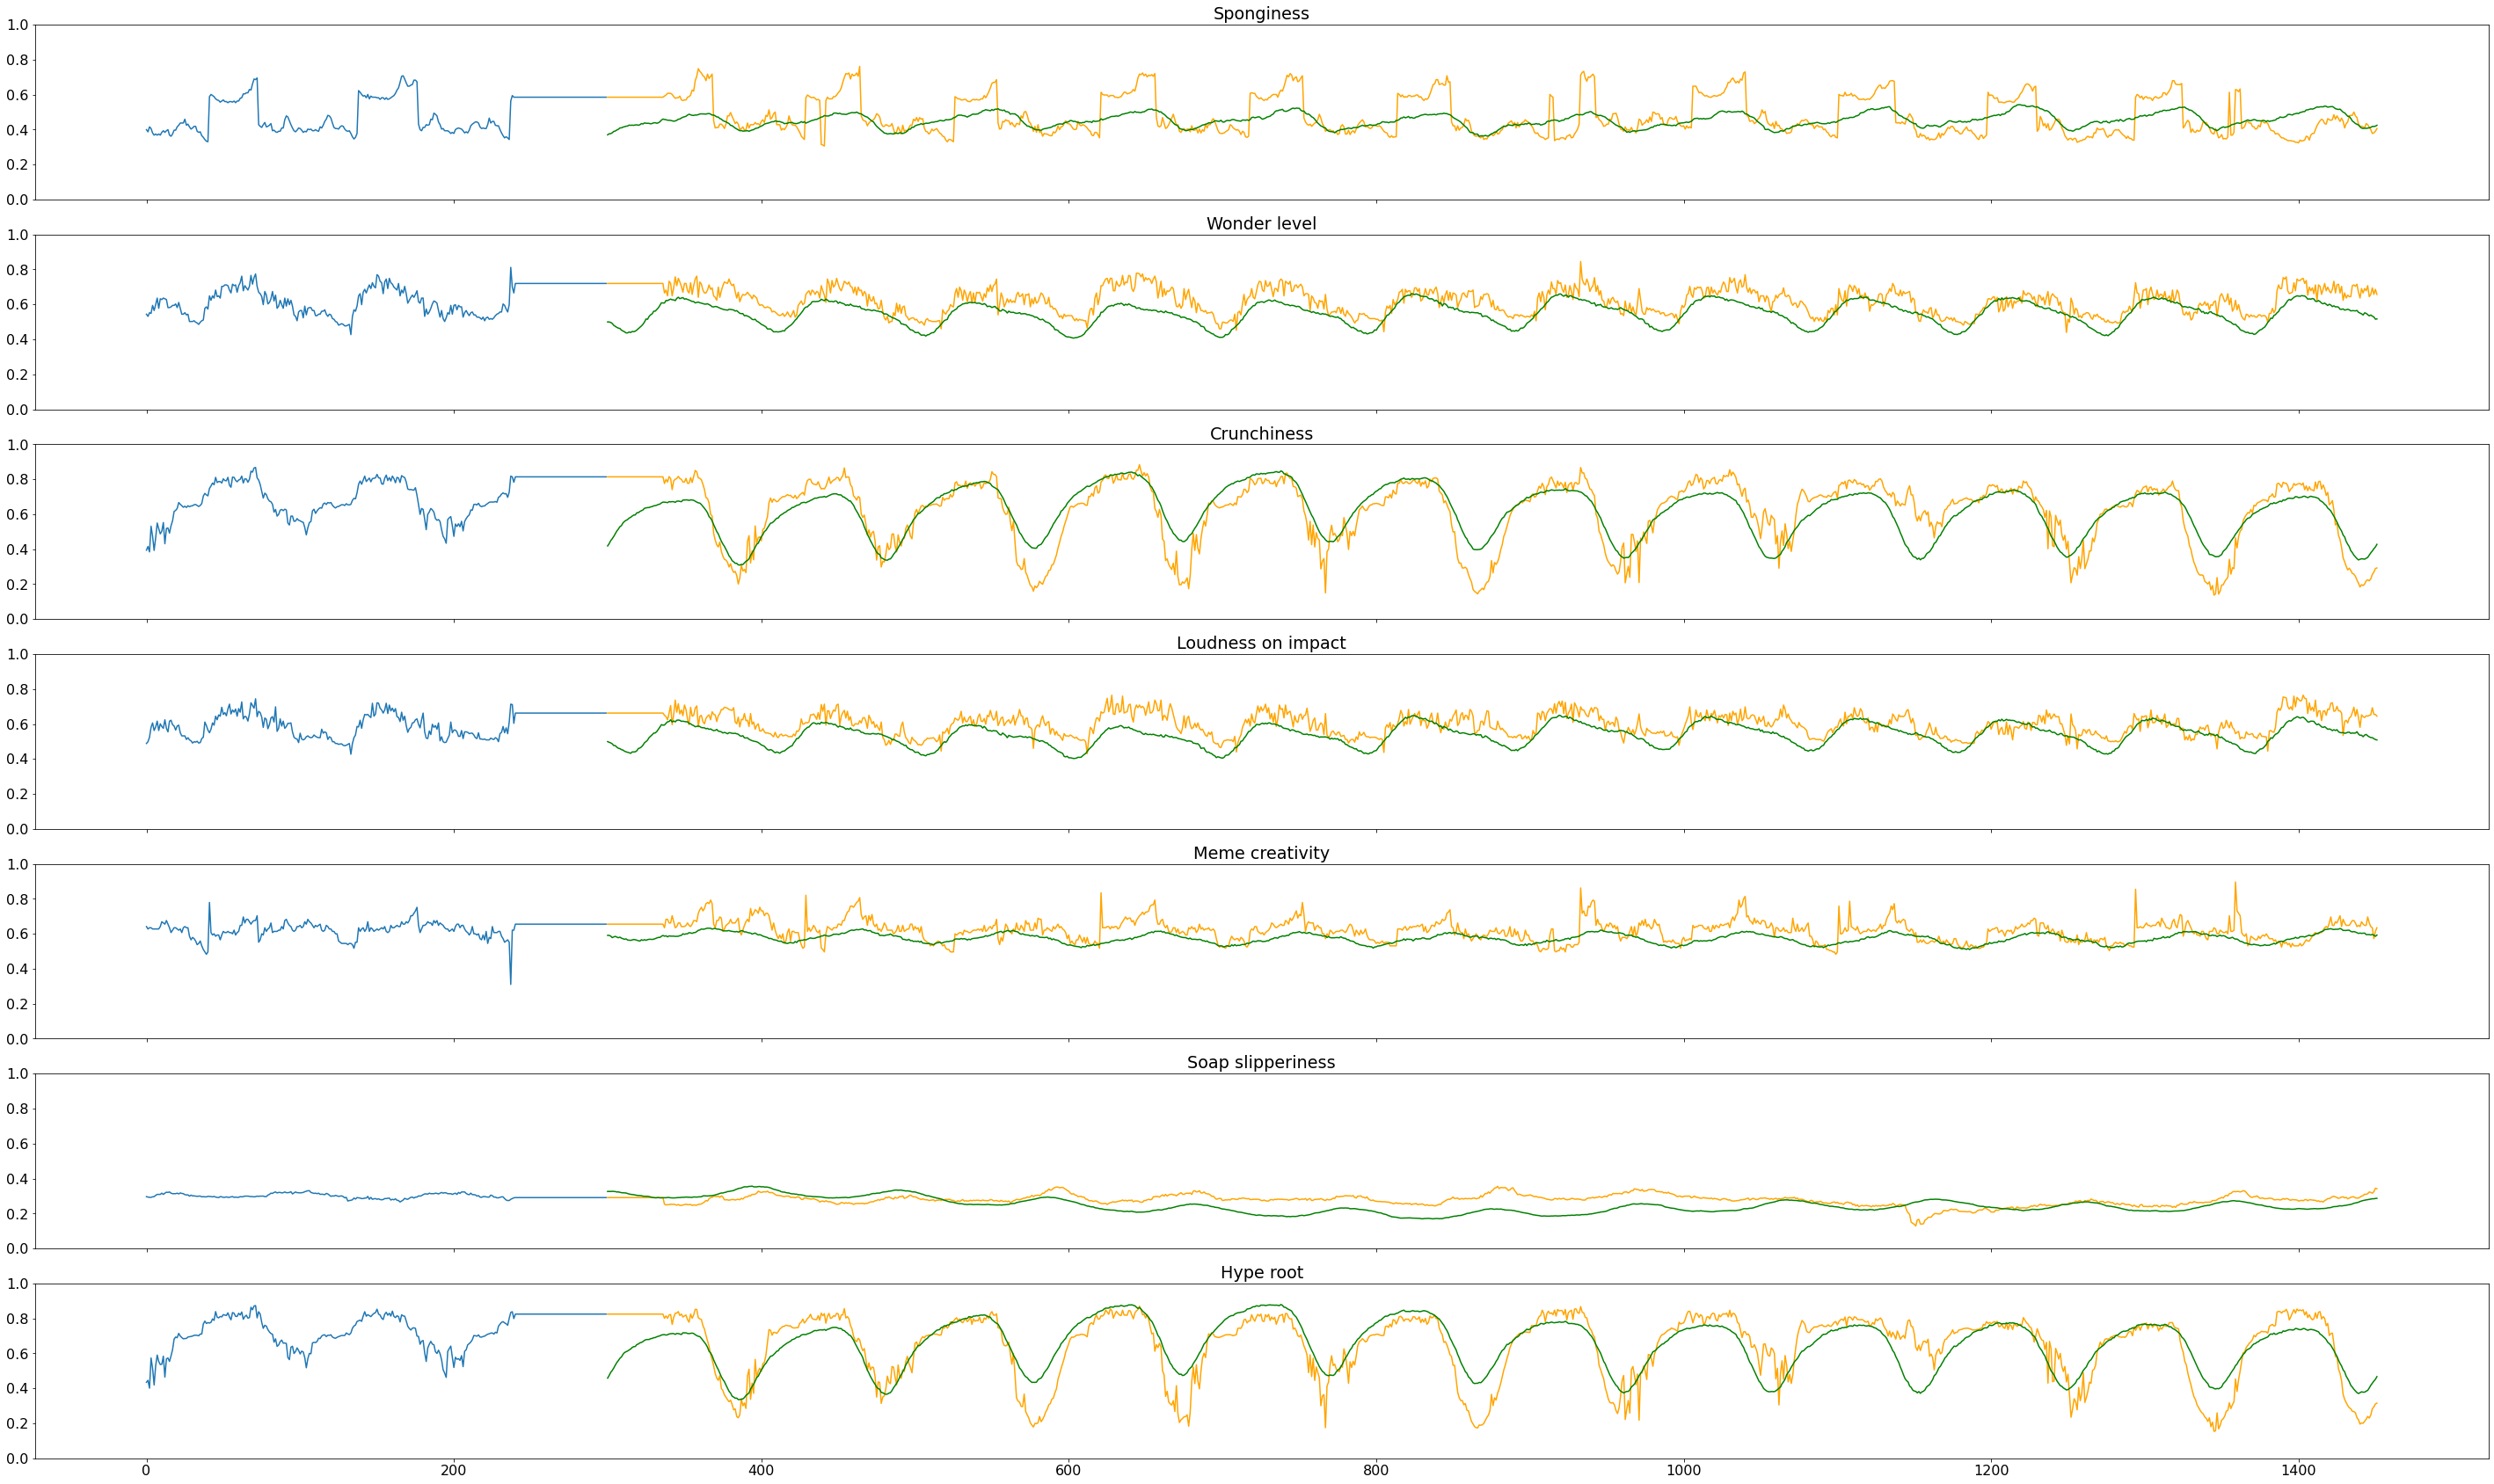

In [25]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)